# Perform Network Analysis
* Create a covariance matrix
* Find an ideal noise-removing threshold filter with Random Matrix Theory
* Analyze properties of the network

**Questions to answer with alpha and beta diversity analysis:**  
* Does the 3G and 3M look like 1C or 2C  
* How do 1G and 1M compare to 1C  
* How does 2G compare to 3G, 2M compare to 3M  
* How does 1C compare to 2C

In [29]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

## Import Data

In [30]:
# load data
df_counts_rel = pd.read_csv("data/processed/FCF_relative_counts_master.csv", index_col=0)
df_annotations = pd.read_csv("data/processed/FCF_annotations_corrected.csv", index_col=0)

print("df_counts_rel.shape", df_counts_rel.shape)
print("df_annotations.shape", df_annotations.shape)

df_counts_rel.shape (86, 153)
df_annotations.shape (86, 5)


In [31]:
df_counts_rel

,opitutus spp.,paludibacter propionicigenes,magnetospirillum sp.,rhodopseudomonas palustris,acetobacter spp.,bacteroides spp.,pleomorphomonas oryzae,afipia sp.,rhodoblastus acidophilus,spirochaeta spp.,...,bosea spp.,corynebacterium durum,rubrivivax gelatinosus,anaerococcus hydrogenalis,globicatella spp.,finegoldia magna,dietzia spp.,granulicatella elegans,actinomyces marimammalium,veillonella dispar
C0C,0.207679,0.186666,0.111385,0.105280,0.074635,0.072615,0.061371,0.051296,0.044397,0.022216,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1C3A,0.266982,0.056341,0.189617,0.127545,0.012517,0.026242,0.050610,0.038828,0.016139,0.003566,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1C3B,0.290483,0.052058,0.163242,0.117690,0.011864,0.026510,0.041061,0.032812,0.011541,0.001880,...,0.0,0.000000,0.000009,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1C5A,0.194116,0.023516,0.294575,0.097889,0.008608,0.018172,0.031574,0.027592,0.024460,0.003168,...,0.0,0.000000,0.000012,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1C5B,0.187870,0.048505,0.132180,0.130451,0.011160,0.036059,0.049378,0.037942,0.025061,0.004889,...,0.0,0.000008,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3G7A,0.144459,0.001801,0.018378,0.065465,0.057839,0.393686,0.159824,0.005029,0.043039,0.000085,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3G7B,0.247657,0.000743,0.023841,0.051781,0.062985,0.275727,0.206768,0.004794,0.026746,0.000102,...,0.0,0.000007,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3G7C,0.228160,0.000888,0.026917,0.059782,0.080850,0.262612,0.185294,0.004707,0.029992,0.000104,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3G10A,0.093492,0.001327,0.096390,0.089828,0.046889,0.383666,0.146778,0.008510,0.051280,0.000005,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Split Samples Into Groups

In [32]:
groups = set(df_annotations["group"])
groups

{'1C', '1G', '1M', '2C', '2G', '2M', '3G', '3M', 'C0C'}

In [33]:
df_counts_rel_1C = df_counts_rel.loc[df_annotations["group"] == "1C", :]
df_counts_rel_1G = df_counts_rel.loc[df_annotations["group"] == "1G", :]
df_counts_rel_1M = df_counts_rel.loc[df_annotations["group"] == "1M", :]
df_counts_rel_2C = df_counts_rel.loc[df_annotations["group"] == "2C", :]
df_counts_rel_2G = df_counts_rel.loc[df_annotations["group"] == "2G", :]
df_counts_rel_2M = df_counts_rel.loc[df_annotations["group"] == "2M", :]
df_counts_rel_3G = df_counts_rel.loc[df_annotations["group"] == "3G", :]
df_counts_rel_3M = df_counts_rel.loc[df_annotations["group"] == "3M", :]

In [34]:
len(df_counts_rel_3M)

12

## Standardize Data For Correlation Analysis

Standardize relative abundance counts by OTU by subtracting the mean across all samples and dividing by variance across all samples. Use this standardized data matrix for all subsequent correlation analysis.

---

Source: Deng Paper

In [35]:
df_counts_rel_1C_stan = df_counts_rel_1C.sub(df_counts_rel_1C.mean(0), axis=1).div(df_counts_rel_1C.std(0), axis=1)
df_counts_rel_1G_stan = df_counts_rel_1G.sub(df_counts_rel_1G.mean(0), axis=1).div(df_counts_rel_1G.std(0), axis=1)
df_counts_rel_1M_stan = df_counts_rel_1M.sub(df_counts_rel_1M.mean(0), axis=1).div(df_counts_rel_1M.std(0), axis=1)
df_counts_rel_2C_stan = df_counts_rel_2C.sub(df_counts_rel_2C.mean(0), axis=1).div(df_counts_rel_2C.std(0), axis=1)
df_counts_rel_2G_stan = df_counts_rel_2G.sub(df_counts_rel_2G.mean(0), axis=1).div(df_counts_rel_2G.std(0), axis=1)
df_counts_rel_2M_stan = df_counts_rel_2M.sub(df_counts_rel_2M.mean(0), axis=1).div(df_counts_rel_2M.std(0), axis=1)
df_counts_rel_3G_stan = df_counts_rel_3G.sub(df_counts_rel_3G.mean(0), axis=1).div(df_counts_rel_3G.std(0), axis=1)
df_counts_rel_3M_stan = df_counts_rel_3M.sub(df_counts_rel_3M.mean(0), axis=1).div(df_counts_rel_3M.std(0), axis=1)

In [36]:
df_counts_rel_3M_stan

,opitutus spp.,paludibacter propionicigenes,magnetospirillum sp.,rhodopseudomonas palustris,acetobacter spp.,bacteroides spp.,pleomorphomonas oryzae,afipia sp.,rhodoblastus acidophilus,spirochaeta spp.,...,bosea spp.,corynebacterium durum,rubrivivax gelatinosus,anaerococcus hydrogenalis,globicatella spp.,finegoldia magna,dietzia spp.,granulicatella elegans,actinomyces marimammalium,veillonella dispar
3M3A,0.737828,-0.756187,-0.716109,-0.766586,-0.727594,-1.158250,-1.111845,-0.977458,2.448633,1.716704,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3M3B,-0.318516,-0.648953,1.572562,-0.738538,-0.710806,-1.295065,-0.305736,-0.098996,-0.386430,1.512753,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3M3C,-1.689498,-0.640769,2.194347,-1.334413,-0.708690,-1.323907,-1.468437,-1.368070,-0.589427,-0.037163,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3M5B,0.667591,-0.148796,-0.773035,-0.492098,-0.286830,0.078213,1.831747,-0.103407,-0.530404,-0.006288,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3M5C,0.079791,-0.402432,-0.571835,-0.183721,-0.704912,0.027657,-0.858348,-0.456020,1.094890,0.462719,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3M5A,0.284504,-0.615221,-0.545445,-0.791596,-0.714287,-0.824016,0.350675,-0.910960,0.834870,0.563396,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3M7A,1.537270,-0.506780,-0.710407,1.690675,-0.376939,-0.107779,0.212116,0.472312,0.230981,-0.392626,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3M7B,-1.413770,0.820874,-0.773399,0.731798,0.401823,1.266768,1.670731,1.590231,-0.777603,-0.165146,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3M7C,1.333359,-0.311347,-0.496935,-0.571038,0.150613,0.633580,-0.016741,-0.967293,-0.729938,0.190756,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3M10A,-0.697500,2.725996,-0.192773,1.734422,2.761679,0.136367,0.298188,1.623975,-0.460592,-1.401053,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
df_counts_rel_1C_stan.mean(0)

opitutus spp.                   4.440892e-17
paludibacter propionicigenes    0.000000e+00
magnetospirillum sp.           -8.881784e-17
rhodopseudomonas palustris     -8.881784e-17
acetobacter spp.               -1.609823e-16
                                    ...     
finegoldia magna                         NaN
dietzia spp.                             NaN
granulicatella elegans                   NaN
actinomyces marimammalium                NaN
veillonella dispar                       NaN
Length: 153, dtype: float64

In [38]:
df_counts_rel_1C_stan.var(0)

opitutus spp.                   1.0
paludibacter propionicigenes    1.0
magnetospirillum sp.            1.0
rhodopseudomonas palustris      1.0
acetobacter spp.                1.0
                               ... 
finegoldia magna                NaN
dietzia spp.                    NaN
granulicatella elegans          NaN
actinomyces marimammalium       NaN
veillonella dispar              NaN
Length: 153, dtype: float64

## Network Construction
* create a pair-wise similarity (Pearson) of abundance across different samples
* determine adjacency matrix by RMT-based approach

In [39]:
import network_analysis_thesholding as nat

## Use Random Matrix Theory To Threshold

Good overview of Random Matrix Theory by [Torsten Scholak](https://tscholak.github.io/code/physics/2015/05/05/unfoldr.html)

TODO: figure out if my Poisson distribution is very off... my chi_squared value seems unreal...

In [40]:
# nat.find_RMT_threshold(df_counts_rel_1G_stan, s_tb=0.3, alpha=0.5)

### Data Is Too Messy
Since the data is too messy, this code lets you eyeball the threshold where the data fits the Poisson distribution more than it fits the GOE distribution.

In [41]:
# threshold = 0.03
# nat.visualize_RMT_threshold(df_counts_rel_1C_stan, threshold)
# nat.visualize_RMT_threshold(df_counts_rel_1G_stan, threshold)
# nat.visualize_RMT_threshold(df_counts_rel_1M_stan, threshold)
# nat.visualize_RMT_threshold(df_counts_rel_2C_stan, threshold)
# nat.visualize_RMT_threshold(df_counts_rel_2G_stan, threshold)
# nat.visualize_RMT_threshold(df_counts_rel_2M_stan, threshold)
# nat.visualize_RMT_threshold(df_counts_rel_3G_stan, threshold)
# nat.visualize_RMT_threshold(df_counts_rel_3M_stan, threshold)

shape (114, 114)


/home/gaher/miniconda3/envs/MBEnv/lib/python3.8/site-packages/empyricalRMT/_validate.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(array, dtype=float)
/home/gaher/miniconda3/envs/MBEnv/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/gaher/miniconda3/envs/MBEnv/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/gaher/miniconda3/envs/MBEnv/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=or

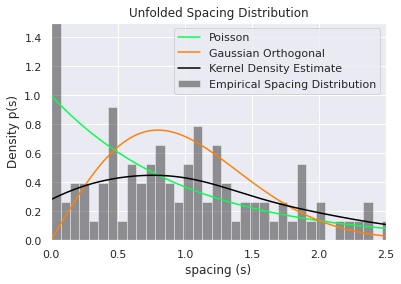

Xsq_poisson (859590179825.2834-3.381017826655288e-06j)
Xsq_crit 138.8113625638847 at alpha=0.05
shape (72, 72)


/home/gaher/miniconda3/envs/MBEnv/lib/python3.8/site-packages/empyricalRMT/_validate.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(array, dtype=float)
/home/gaher/miniconda3/envs/MBEnv/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/gaher/miniconda3/envs/MBEnv/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/gaher/miniconda3/envs/MBEnv/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=or

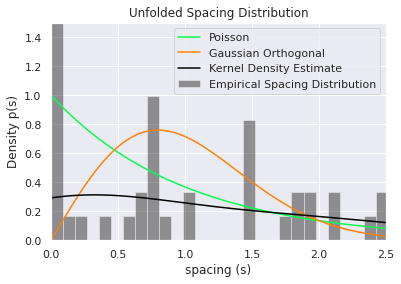

Xsq_poisson (13644537792.55788-7.359873207833286e-08j)
Xsq_crit 91.67023917605484 at alpha=0.05
shape (84, 84)


/home/gaher/miniconda3/envs/MBEnv/lib/python3.8/site-packages/empyricalRMT/_validate.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(array, dtype=float)
/home/gaher/miniconda3/envs/MBEnv/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/gaher/miniconda3/envs/MBEnv/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/gaher/miniconda3/envs/MBEnv/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=or

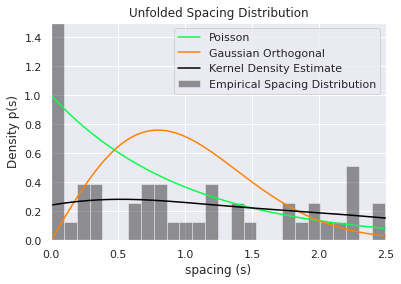

Xsq_poisson (1214283299575.7893-3.3270568538816516e-06j)
Xsq_crit 105.26717729686034 at alpha=0.05
shape (118, 118)


/home/gaher/miniconda3/envs/MBEnv/lib/python3.8/site-packages/empyricalRMT/_validate.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(array, dtype=float)
/home/gaher/miniconda3/envs/MBEnv/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/gaher/miniconda3/envs/MBEnv/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/gaher/miniconda3/envs/MBEnv/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=or

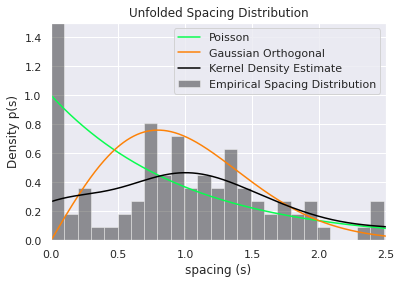

Xsq_poisson (1904809918121.876-1.0885534229813028e-06j)
Xsq_crit 143.24614728377486 at alpha=0.05
shape (121, 121)


/home/gaher/miniconda3/envs/MBEnv/lib/python3.8/site-packages/empyricalRMT/_validate.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(array, dtype=float)
/home/gaher/miniconda3/envs/MBEnv/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/gaher/miniconda3/envs/MBEnv/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/gaher/miniconda3/envs/MBEnv/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=or

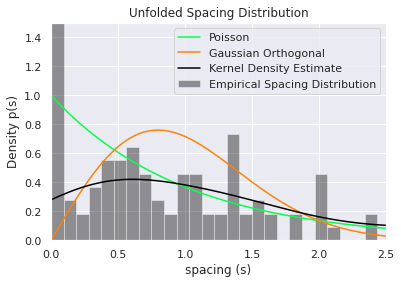

Xsq_poisson (1999522772.49738-2.1029091631772637e-10j)
Xsq_crit 146.56735758076744 at alpha=0.05
shape (127, 127)


/home/gaher/miniconda3/envs/MBEnv/lib/python3.8/site-packages/empyricalRMT/_validate.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(array, dtype=float)
/home/gaher/miniconda3/envs/MBEnv/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/gaher/miniconda3/envs/MBEnv/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/gaher/miniconda3/envs/MBEnv/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=or

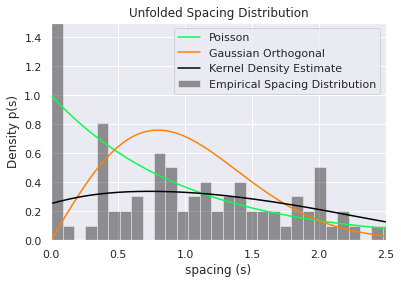

Xsq_poisson (99237566089842.2-0.0006038169849456157j)
Xsq_crit 153.1979027439562 at alpha=0.05
shape (100, 100)


/home/gaher/miniconda3/envs/MBEnv/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


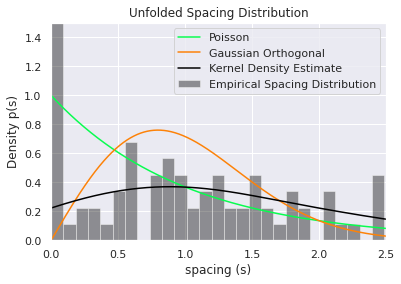

Xsq_poisson 397838623.98974097
Xsq_crit 123.2252214533618 at alpha=0.05
shape (104, 104)


/home/gaher/miniconda3/envs/MBEnv/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


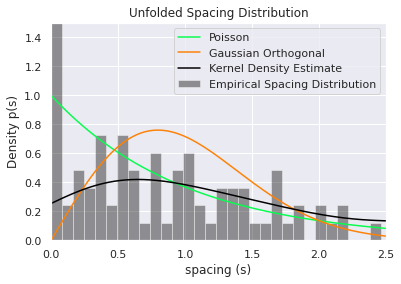

Xsq_poisson 8376307573.361557
Xsq_crit 127.68930826333825 at alpha=0.05


In [42]:
threshold = 0.76
nat.visualize_RMT_threshold(df_counts_rel_1C_stan, threshold)
nat.visualize_RMT_threshold(df_counts_rel_1G_stan, threshold)
nat.visualize_RMT_threshold(df_counts_rel_1M_stan, threshold)
nat.visualize_RMT_threshold(df_counts_rel_2C_stan, threshold)
nat.visualize_RMT_threshold(df_counts_rel_2G_stan, threshold)
nat.visualize_RMT_threshold(df_counts_rel_2M_stan, threshold)
nat.visualize_RMT_threshold(df_counts_rel_3G_stan, threshold)
nat.visualize_RMT_threshold(df_counts_rel_3M_stan, threshold)

In [43]:
df_adjm_1C = nat.get_thresholded_matrix(nat.get_similarity_matrix(df_counts_rel_1C), threshold)
df_adjm_1G = nat.get_thresholded_matrix(nat.get_similarity_matrix(df_counts_rel_1G), threshold)
df_adjm_1M = nat.get_thresholded_matrix(nat.get_similarity_matrix(df_counts_rel_1M), threshold)
df_adjm_2C = nat.get_thresholded_matrix(nat.get_similarity_matrix(df_counts_rel_2C), threshold)
df_adjm_2G = nat.get_thresholded_matrix(nat.get_similarity_matrix(df_counts_rel_2G), threshold)
df_adjm_2M = nat.get_thresholded_matrix(nat.get_similarity_matrix(df_counts_rel_2M), threshold)
df_adjm_3G = nat.get_thresholded_matrix(nat.get_similarity_matrix(df_counts_rel_3G), threshold)
df_adjm_3M = nat.get_thresholded_matrix(nat.get_similarity_matrix(df_counts_rel_3M), threshold)

shape (114, 114)
shape (72, 72)
shape (84, 84)
shape (118, 118)
shape (121, 121)
shape (127, 127)
shape (100, 100)
shape (104, 104)


In [44]:
df_adjm_1C = nat.get_thresholded_matrix(nat.get_similarity_matrix(df_counts_rel_1C_stan), threshold)
df_adjm_1G = nat.get_thresholded_matrix(nat.get_similarity_matrix(df_counts_rel_1G_stan), threshold)
df_adjm_1M = nat.get_thresholded_matrix(nat.get_similarity_matrix(df_counts_rel_1M_stan), threshold)
df_adjm_2C = nat.get_thresholded_matrix(nat.get_similarity_matrix(df_counts_rel_2C_stan), threshold)
df_adjm_2G = nat.get_thresholded_matrix(nat.get_similarity_matrix(df_counts_rel_2G_stan), threshold)
df_adjm_2M = nat.get_thresholded_matrix(nat.get_similarity_matrix(df_counts_rel_2M_stan), threshold)
df_adjm_3G = nat.get_thresholded_matrix(nat.get_similarity_matrix(df_counts_rel_3G_stan), threshold)
df_adjm_3M = nat.get_thresholded_matrix(nat.get_similarity_matrix(df_counts_rel_3M_stan), threshold)

shape (114, 114)
shape (72, 72)
shape (84, 84)
shape (118, 118)
shape (121, 121)
shape (127, 127)
shape (100, 100)
shape (104, 104)


In [45]:
# save adjacency matrices
df_adjm_1C.to_csv(f"results/adjm/df_adjm_1C_{round(threshold*100)}.csv")
df_adjm_1G.to_csv(f"results/adjm/df_adjm_1G_{round(threshold*100)}.csv")
df_adjm_1M.to_csv(f"results/adjm/df_adjm_1M_{round(threshold*100)}.csv")
df_adjm_2C.to_csv(f"results/adjm/df_adjm_2C_{round(threshold*100)}.csv")
df_adjm_2G.to_csv(f"results/adjm/df_adjm_2G_{round(threshold*100)}.csv")
df_adjm_2M.to_csv(f"results/adjm/df_adjm_2M_{round(threshold*100)}.csv")
df_adjm_3G.to_csv(f"results/adjm/df_adjm_3G_{round(threshold*100)}.csv")
df_adjm_3M.to_csv(f"results/adjm/df_adjm_3M_{round(threshold*100)}.csv")

In [46]:
df_adjm_3M

,opitutus spp.,paludibacter propionicigenes,magnetospirillum sp.,rhodopseudomonas palustris,acetobacter spp.,bacteroides spp.,pleomorphomonas oryzae,afipia sp.,rhodoblastus acidophilus,spirochaeta spp.,...,oribacterium sinus,flexithrix dorotheae,methylococcus capsulatus,methylopila sp.,enhydrobacter aerosaccus,burkholderia ubonensis,aeromonas spp.,methylocystis sp.,sphingomonas faeni,lactobacillus helveticus
opitutus spp.,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
paludibacter propionicigenes,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
magnetospirillum sp.,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
rhodopseudomonas palustris,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
acetobacter spp.,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
burkholderia ubonensis,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aeromonas spp.,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
methylocystis sp.,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
sphingomonas faeni,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


## Analyze Network Properties:

**Key Characteristics:**
* k-core, average path length, local clustering coefficient
* the average degree, degree distribution
* module, clique, motif

**Density:** tells you how connected a network is. A 0 density would mean that there are no connections at all, and a 1 would indicate that all possible edges are present (a perfectly connected network).

**Transitivity:** like density, expresses how interconnected a graph is in terms of a ratio of actual over possible connections. A triangle is formed if two nodes that are connected to a node are also connected to each other.

There are many network metrics derived from shortest path lengths. One such measure is **diameter**, which is the longest of all shortest paths. After calculating all shortest paths between every possible pair of nodes in the network, diameter is the length of the path between the two nodes that are furthest apart. The measure is designed to give you a sense of the network’s overall size, the distance from one end of the network to another.

After getting some basic measures of the entire network structure, a good next step is to find which nodes are the most important ones in your network. In network analysis, measures of the importance of nodes are referred to as centrality measures. Because there are many ways of approaching the question “Which nodes are the most important?” there are many different ways of calculating centrality. Here you’ll learn about three of the most common centrality measures: degree, betweenness centrality, and eigenvector centrality.

**Features of Nodes:**
* degree, degree centrality
* node-betweenness, node-betweenness centrality
* closeness, cluster coefficient, coreness
* eigenvector centrality

**Degree Distribution:** Most networks will have just a few hubs of very high degree, with the rest of similar, much lower degree

**Eigenvector centrality:** is a kind of extension of degree—it looks at a combination of a node’s edges and the edges of that node’s neighbors. Eigenvector centrality cares if you are a hub, but it also cares how many hubs you are connected to. It’s calculated as a value from 0 to 1: the closer to one, the greater the centrality. Eigenvector centrality is useful for understanding which nodes can get information to many other nodes quickly. If you know a lot of well-connected people, you could spread a message very efficiently. If you’ve used Google, then you’re already somewhat familiar with Eigenvector centrality. Their PageRank algorithm uses an extension of this formula to decide which webpages get to the top of its search results.

**Betweenness centrality:** is a bit different from the other two measures in that it doesn’t care about the number of edges any one node or set of nodes has. Betweenness centrality looks at all the shortest paths that pass through a particular node (see above). To do this, it must first calculate every possible shortest path in your network, so keep in mind that betweenness centrality will take longer to calculate than other centrality measures (but it won’t be an issue in a dataset of this size). Betweenness centrality, which is also expressed on a scale of 0 to 1, is fairly good at finding nodes that connect two otherwise disparate parts of a network. If you’re the only thing connecting two clusters, every communication between those clusters has to pass through you. In contrast to a hub, this sort of node is often referred to as a broker. Betweenness centrality is not the only way of finding brokerage (and other methods are more systematic), but it’s a quick way of giving you a sense of which nodes are important not because they have lots of connections themselves but because they stand between groups, giving the network connectivity and cohesion.

Read More Here: [Social Network Analysis: From Graph Theory to Applications with Python](https://towardsdatascience.com/social-network-analysis-from-theory-to-applications-with-python-d12e9a34c2c7)

---

**Features of Edges:**
* shortest path, distance
* edge-betweenness

Sources:
* https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python

---

### Community detection with modularity

There are many ways of calculating communities, cliques, and clusters in your network, but the most popular method currently is modularity. Modularity is a measure of relative density in your network: a community (called a module or modularity class) has high density relative to other nodes within its module but low density with those outside. Modularity gives you an overall score of how fractious your network is, and that score can be used to partition the network and return the individual communities.

After all modules are separated, each node can be
assigned a role based on its topological properties and the role of node i is characterized by its within-module connectivity (zi) and among-module connectivity (Pi)

If all links of node i only belong to its own module, Pi = 0.  
If the links of node i are distributed evenly among modules, Pi --> 1.

Peripheral nodes:     zi <= 2.5, Pi <= 0.62  
Connector nodes:      zi <= 2.5, Pi > 0.62  
Module hub nodes:     zi > 2.5,  Pi <= 0.62  
Network hub nodes:    zi > 2.5,  Pi > 0.62  

Sources:
* https://www.researchgate.net/post/How_should_I_interpret_the_connectivity_measures_kTotal_kWithin_kOut_kDiff_in_WGCNA
* MENAP paper

In [47]:
import network_analysis_properties as nap
import networkx as nx 

In [48]:
G_1C = nap.get_network_from_adjm(df_adjm_1C, name="1C")
G_1G = nap.get_network_from_adjm(df_adjm_1G, name="1G")
G_1M = nap.get_network_from_adjm(df_adjm_1M, name="1M")
G_2C = nap.get_network_from_adjm(df_adjm_2C, name="2C")
G_2G = nap.get_network_from_adjm(df_adjm_2G, name="2G")
G_2M = nap.get_network_from_adjm(df_adjm_2M, name="2M")
G_3G = nap.get_network_from_adjm(df_adjm_3G, name="3G")
G_3M = nap.get_network_from_adjm(df_adjm_3M, name="3M")

df_eigen_1C, df_eigengenes_1C = nap.get_leading_eigengenes(G_1C, df_counts_rel_1C_stan, set_node_module_membership=True)
df_eigen_1G, df_eigengenes_1G = nap.get_leading_eigengenes(G_1G, df_counts_rel_1G_stan, set_node_module_membership=True)
df_eigen_1M, df_eigengenes_1M = nap.get_leading_eigengenes(G_1M, df_counts_rel_1M_stan, set_node_module_membership=True)
df_eigen_2C, df_eigengenes_2C = nap.get_leading_eigengenes(G_2C, df_counts_rel_2C_stan, set_node_module_membership=True)
df_eigen_2G, df_eigengenes_2G = nap.get_leading_eigengenes(G_2G, df_counts_rel_2G_stan, set_node_module_membership=True)
df_eigen_2M, df_eigengenes_2M = nap.get_leading_eigengenes(G_2M, df_counts_rel_2M_stan, set_node_module_membership=True)
df_eigen_3G, df_eigengenes_3G = nap.get_leading_eigengenes(G_3G, df_counts_rel_3G_stan, set_node_module_membership=True)
df_eigen_3M, df_eigengenes_3M = nap.get_leading_eigengenes(G_3M, df_counts_rel_3M_stan, set_node_module_membership=True)

Gs = [G_1C, G_1G, G_1M, G_2C, G_2G, G_2M, G_3G, G_3M]

setting node_module_membership for 1C graph
setting node_module_membership for 1G graph
setting node_module_membership for 1M graph
setting node_module_membership for 2C graph
setting node_module_membership for 2G graph
setting node_module_membership for 2M graph
setting node_module_membership for 3G graph
setting node_module_membership for 3M graph


In [49]:
# save network properties to csv
nap.networks_attributes_to_csv(Gs, f"results/network/df_network_properties_{round(threshold*100)}.csv")

,number_of_nodes,number_of_edges,density,transitivity,network_is_connected,network_diameter_of_largest_component,modularity_score,number_of_modules,number_of_peripheral_node,number_of_connector_node,number_of_module_hub_node,number_of_network_hub_node
1C,114.0,416.0,0.064586,0.611970,False,11.0,0.599029,8.0,33.0,80.0,0.0,1.0
1G,72.0,218.0,0.085290,0.686099,False,6.0,0.499874,11.0,25.0,47.0,0.0,0.0
1M,84.0,257.0,0.073723,0.833407,False,12.0,0.657383,12.0,22.0,62.0,0.0,0.0
2C,118.0,844.0,0.122266,0.665065,True,7.0,0.488845,6.0,52.0,66.0,0.0,0.0
2G,121.0,454.0,0.062534,0.702143,True,13.0,0.745646,7.0,39.0,82.0,0.0,0.0
2M,127.0,868.0,0.108486,0.799693,False,12.0,0.546086,11.0,45.0,82.0,0.0,0.0
3G,100.0,238.0,0.048081,0.512983,False,10.0,0.630596,14.0,21.0,79.0,0.0,0.0
3M,104.0,313.0,0.058439,0.633424,False,11.0,0.656988,11.0,26.0,78.0,0.0,0.0


In [50]:
# save node properties to csv
nap.nodes_attributes_to_csv(G_1C, f"results/network/df_network_1C_{round(threshold*100)}.csv")
nap.nodes_attributes_to_csv(G_1G, f"results/network/df_network_1G_{round(threshold*100)}.csv")
nap.nodes_attributes_to_csv(G_1M, f"results/network/df_network_1M_{round(threshold*100)}.csv")
nap.nodes_attributes_to_csv(G_2C, f"results/network/df_network_2C_{round(threshold*100)}.csv")
nap.nodes_attributes_to_csv(G_2G, f"results/network/df_network_2G_{round(threshold*100)}.csv")
nap.nodes_attributes_to_csv(G_2M, f"results/network/df_network_2M_{round(threshold*100)}.csv")
nap.nodes_attributes_to_csv(G_3G, f"results/network/df_network_3G_{round(threshold*100)}.csv")
nap.nodes_attributes_to_csv(G_3M, f"results/network/df_network_3M_{round(threshold*100)}.csv")

saving to results/network/df_network_1C_76.csv
saving to results/network/df_network_1G_76.csv
saving to results/network/df_network_1M_76.csv
saving to results/network/df_network_2C_76.csv
saving to results/network/df_network_2G_76.csv
saving to results/network/df_network_2M_76.csv
saving to results/network/df_network_3G_76.csv
saving to results/network/df_network_3M_76.csv


,node_role,betweenness,within_module_connectivity,within_module_degree,degree,among_module_connectivity,eigenvector_centrality,node_module_membership,modularity
opitutus spp.,peripheral_node,0,-1.43306,1,1,0,0.0214236,0.0437631,0
paludibacter propionicigenes,connector_node,0.0588672,0.318981,6,8,1,9.59856e-05,0.23918,1
magnetospirillum sp.,connector_node,0,-1.11803,1,1,1,1.02591e-17,0.341787,4
rhodopseudomonas palustris,connector_node,0.0143242,-0.884538,1,2,1,1.26685e-05,-0.43495,3
acetobacter spp.,connector_node,0.162812,-0.0996815,5,10,1,0.000104951,0.0787083,1
...,...,...,...,...,...,...,...,...,...
burkholderia ubonensis,connector_node,0,-1.77433,1,1,1,2.43103e-05,0.0439975,1
aeromonas spp.,peripheral_node,0,-1.01442,3,3,0,0.0065698,-0.38143,0
methylocystis sp.,connector_node,0,0,4,4,1,-4.24546e-18,-0.712361,6
sphingomonas faeni,peripheral_node,0,-1.01442,3,3,0,0.0065698,-0.196971,0


In [51]:
# save module eigenvalues and eigengenes to csv
df_eigen_1C.to_csv(f"results/network_module_eig/df_module_eigenvalues_1C_{round(threshold*100)}.csv")
df_eigen_1G.to_csv(f"results/network_module_eig/df_module_eigenvalues_1G_{round(threshold*100)}.csv")
df_eigen_1M.to_csv(f"results/network_module_eig/df_module_eigenvalues_1M_{round(threshold*100)}.csv")
df_eigen_2C.to_csv(f"results/network_module_eig/df_module_eigenvalues_2C_{round(threshold*100)}.csv")
df_eigen_2G.to_csv(f"results/network_module_eig/df_module_eigenvalues_2G_{round(threshold*100)}.csv")
df_eigen_2M.to_csv(f"results/network_module_eig/df_module_eigenvalues_2M_{round(threshold*100)}.csv")
df_eigen_3G.to_csv(f"results/network_module_eig/df_module_eigenvalues_3G_{round(threshold*100)}.csv")
df_eigen_3M.to_csv(f"results/network_module_eig/df_module_eigenvalues_3M_{round(threshold*100)}.csv")

df_eigengenes_1C.to_csv(f"results/network_module_eig/df_module_eigengenes_1C_{round(threshold*100)}.csv")
df_eigengenes_1G.to_csv(f"results/network_module_eig/df_module_eigengenes_1G_{round(threshold*100)}.csv")
df_eigengenes_1M.to_csv(f"results/network_module_eig/df_module_eigengenes_1M_{round(threshold*100)}.csv") 
df_eigengenes_2C.to_csv(f"results/network_module_eig/df_module_eigengenes_2C_{round(threshold*100)}.csv")
df_eigengenes_2G.to_csv(f"results/network_module_eig/df_module_eigengenes_2G_{round(threshold*100)}.csv")
df_eigengenes_2M.to_csv(f"results/network_module_eig/df_module_eigengenes_2M_{round(threshold*100)}.csv")
df_eigengenes_3G.to_csv(f"results/network_module_eig/df_module_eigengenes_3G_{round(threshold*100)}.csv")
df_eigengenes_3M.to_csv(f"results/network_module_eig/df_module_eigengenes_3M_{round(threshold*100)}.csv")

In [52]:
print("list of node attributes:", set([k for n in G_1C.nodes for k in G_1C.nodes[n].keys()]))

# attribute = "degree"
# nap.display_sorted_property(G_1C, attribute=attribute)
# nap.display_sorted_property(G_1G, attribute=attribute)
# nap.display_sorted_property(G_1M, attribute=attribute)
# nap.display_sorted_property(G_2C, attribute=attribute)
# nap.display_sorted_property(G_2G, attribute=attribute)
# nap.display_sorted_property(G_2M, attribute=attribute)
# nap.display_sorted_property(G_3G, attribute=attribute)
# nap.display_sorted_property(G_3M, attribute=attribute)

list of node attributes: {'node_role', 'betweenness', 'within_module_connectivity', 'within_module_degree', 'degree', 'among_module_connectivity', 'eigenvector_centrality', 'node_module_membership', 'modularity'}


## Visualize Network

### Default Layout

In [53]:
# for G in Gs:
#     nap.visualize_network(G)

### Try Circular Layout

In [54]:
# for G in Gs:
#     nap.visualize_network(G, layout="circular")

## Fancy Styling

special opitutus spp. in module 0
special magnetospirillum sp. in module 0
special rhodopseudomonas palustris in module 0
special pleomorphomonas oryzae in module 0
special eubacterium sp. in module 1
1C: specials 5 | eigenvector centrality min: 8.902895627221542e-30 | max: 0.26240645401411916)


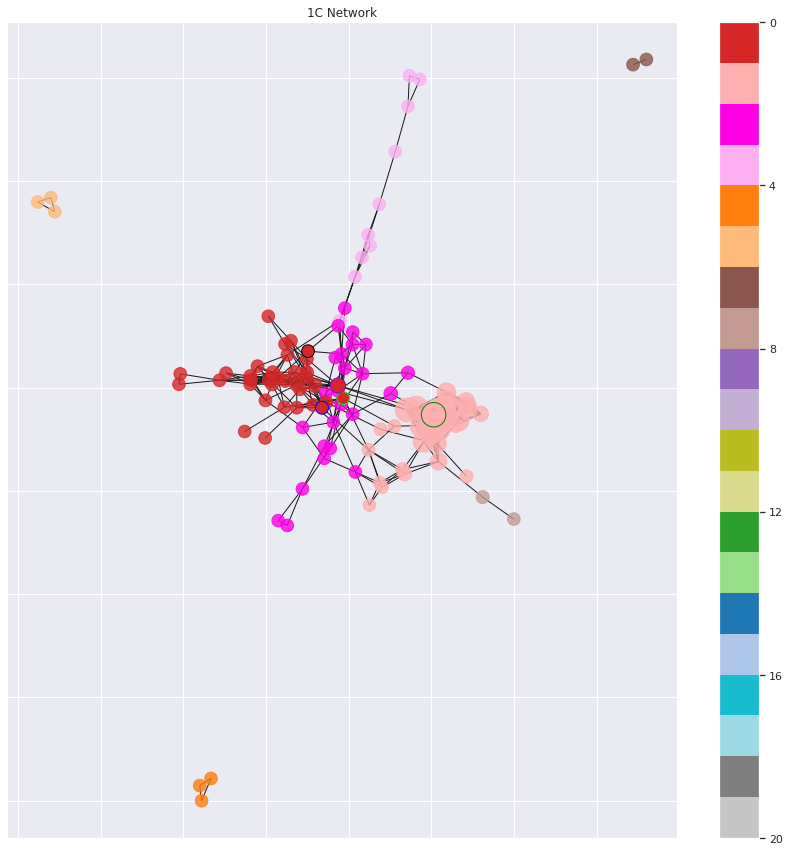

In [55]:
nap.visualize_network_fancy(G_1C)

special magnetospirillum sp. in module 7
special rhodopseudomonas palustris in module 5
special pleomorphomonas oryzae in module 7
special eubacterium sp. in module 0
1G: specials 4 | eigenvector centrality min: 4.478598296298908e-14 | max: 0.15853547184058764)


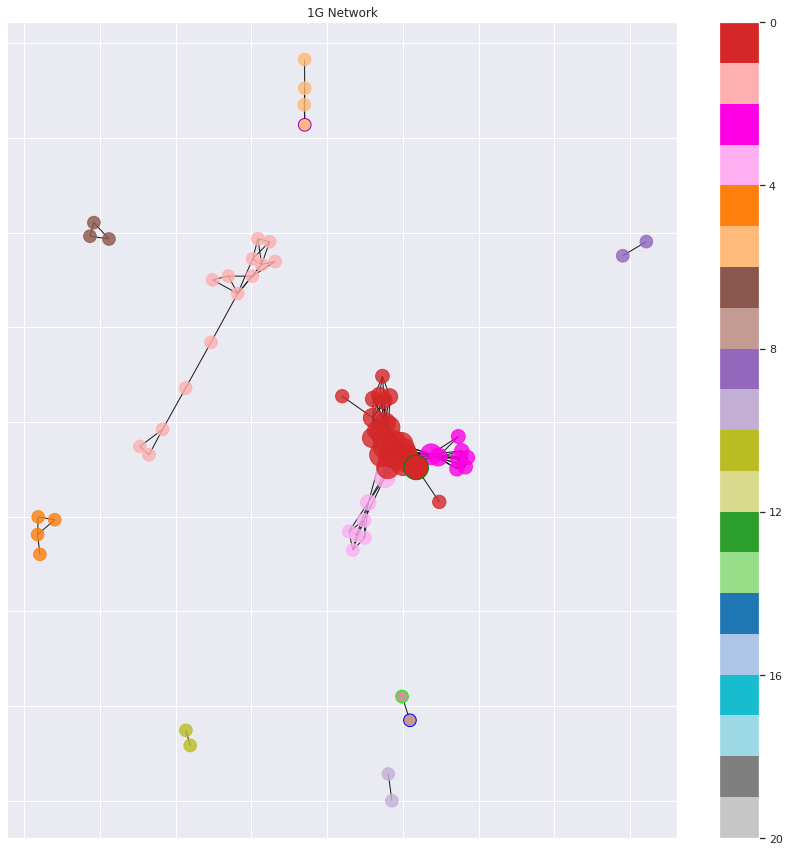

In [56]:
nap.visualize_network_fancy(G_1G)

special magnetospirillum sp. in module 2
special rhodopseudomonas palustris in module 2
1M: specials 2 | eigenvector centrality min: 3.330652895949439e-32 | max: 1.926158903812563e-05)


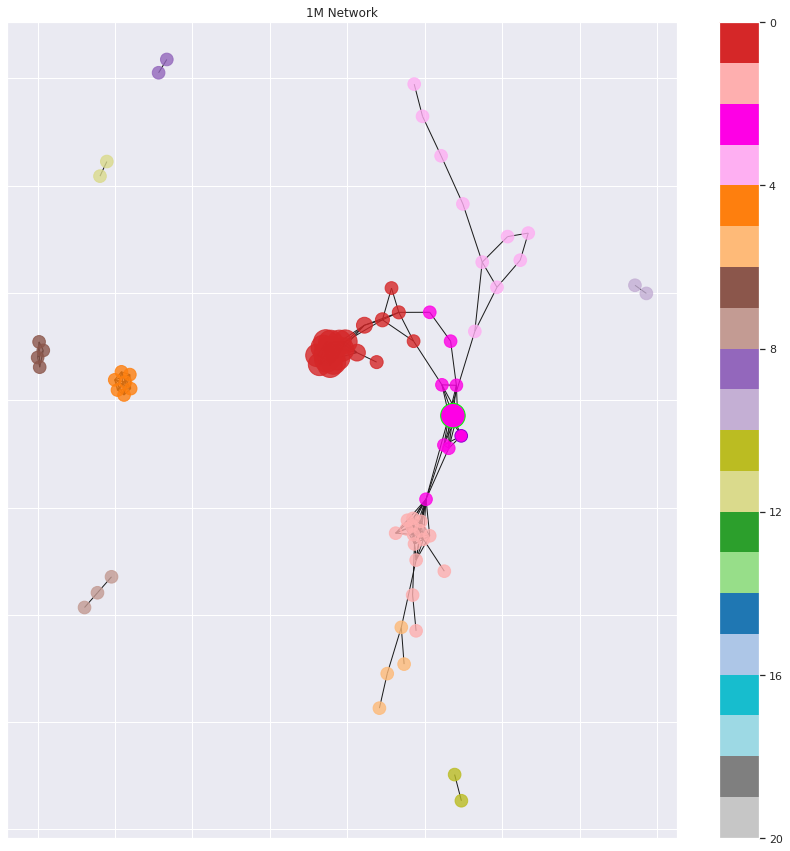

In [57]:
nap.visualize_network_fancy(G_1M)

special opitutus spp. in module 3
special magnetospirillum sp. in module 1
special rhodopseudomonas palustris in module 0
special pleomorphomonas oryzae in module 1
special eubacterium sp. in module 0
2C: specials 5 | eigenvector centrality min: 1.5812893257748734e-05 | max: 0.18499482679045992)


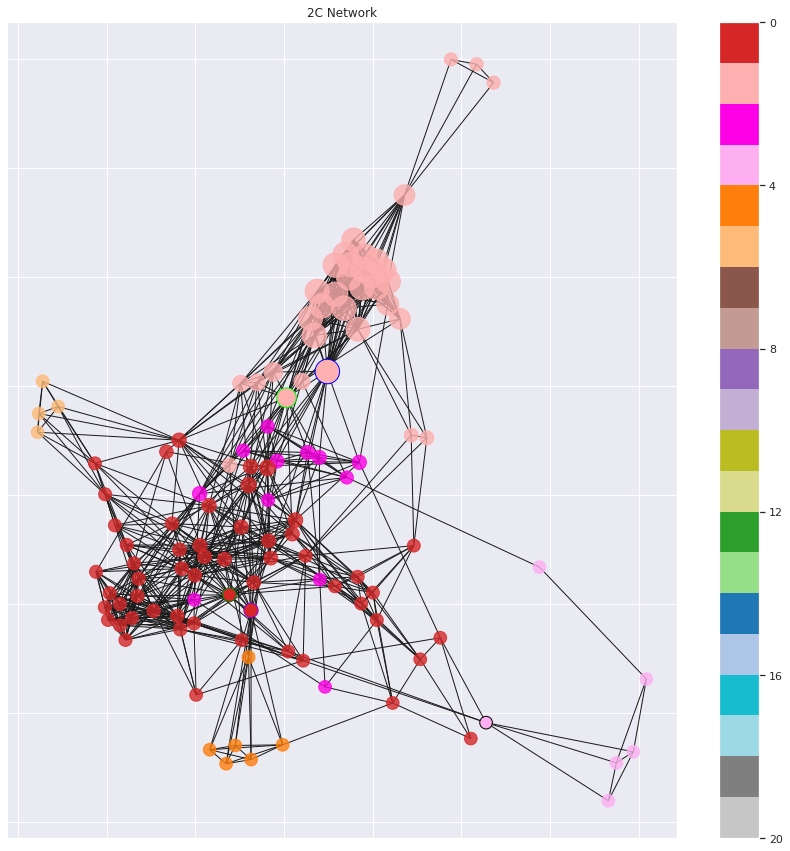

In [58]:
nap.visualize_network_fancy(G_2C)

special opitutus spp. in module 1
special magnetospirillum sp. in module 0
special rhodopseudomonas palustris in module 0
special pleomorphomonas oryzae in module 1
special eubacterium sp. in module 0
2G: specials 5 | eigenvector centrality min: 4.844459946150888e-07 | max: 0.2853806242298842)


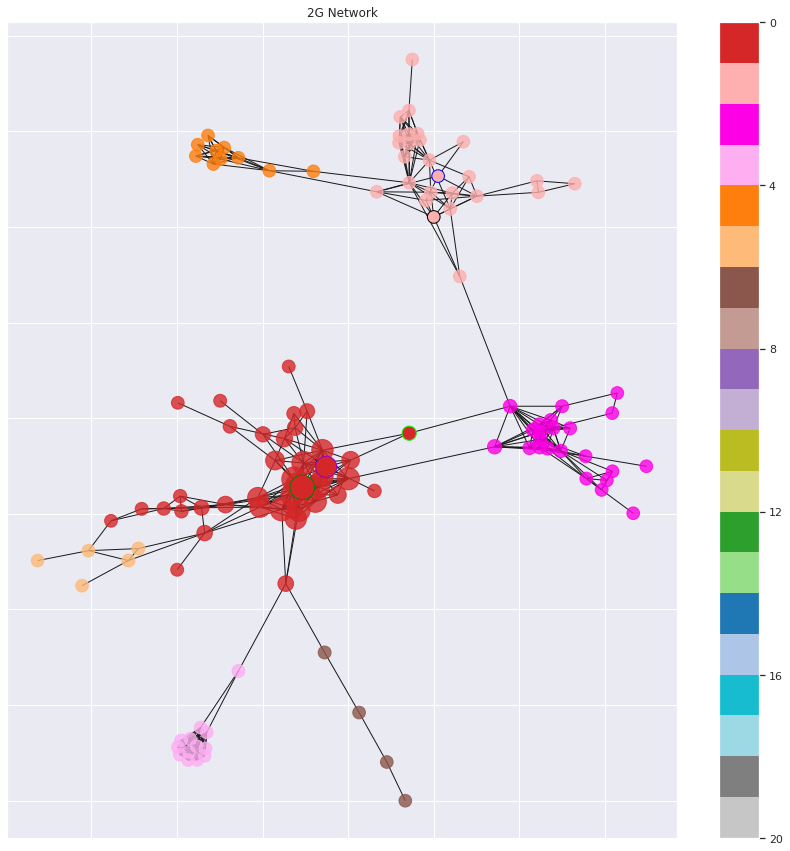

In [59]:
nap.visualize_network_fancy(G_2G)

special opitutus spp. in module 5
special magnetospirillum sp. in module 0
special rhodopseudomonas palustris in module 0
special pleomorphomonas oryzae in module 1
special eubacterium sp. in module 1
2M: specials 5 | eigenvector centrality min: 3.63517669453447e-37 | max: 0.045034095631358004)


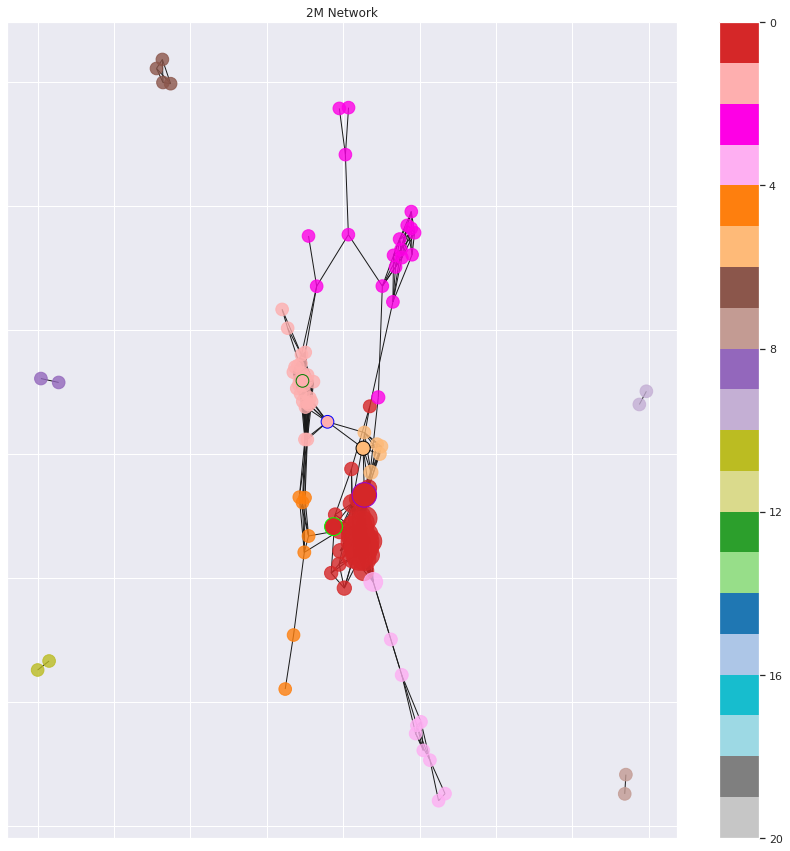

In [60]:
nap.visualize_network_fancy(G_2M)

special opitutus spp. in module 0
special magnetospirillum sp. in module 0
special rhodopseudomonas palustris in module 0
special pleomorphomonas oryzae in module 0
special eubacterium sp. in module 3
3G: specials 5 | eigenvector centrality min: 3.910762899543128e-36 | max: 0.28661602670780517)


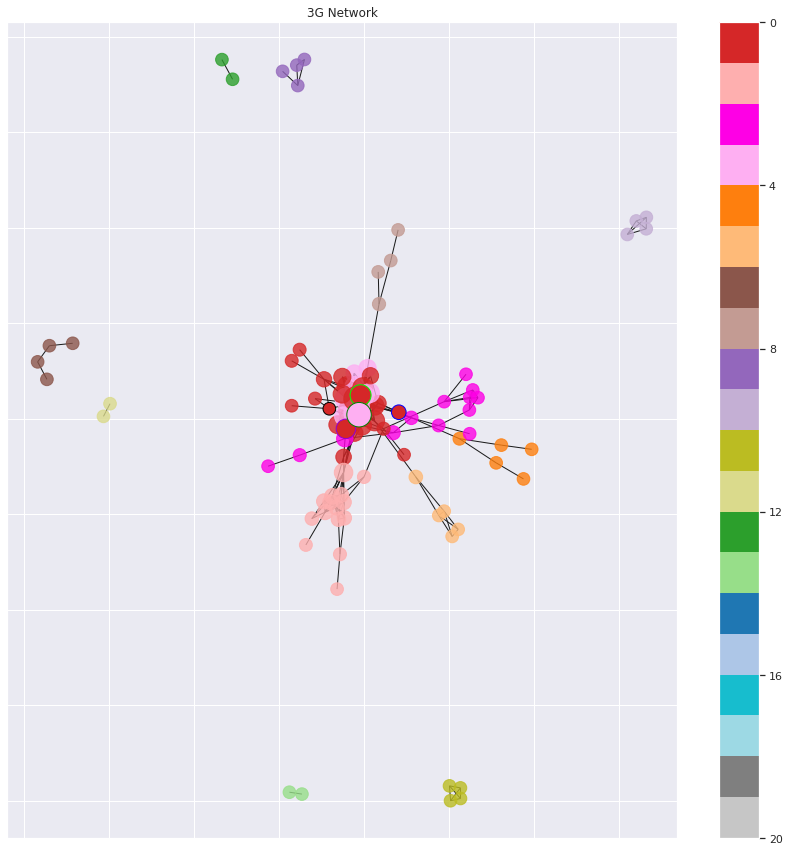

In [61]:
nap.visualize_network_fancy(G_3G)

special opitutus spp. in module 0
special magnetospirillum sp. in module 4
special rhodopseudomonas palustris in module 3
special pleomorphomonas oryzae in module 1
special eubacterium sp. in module 0
3M: specials 5 | eigenvector centrality min: -2.466583786430057e-17 | max: 0.29972747344208095)


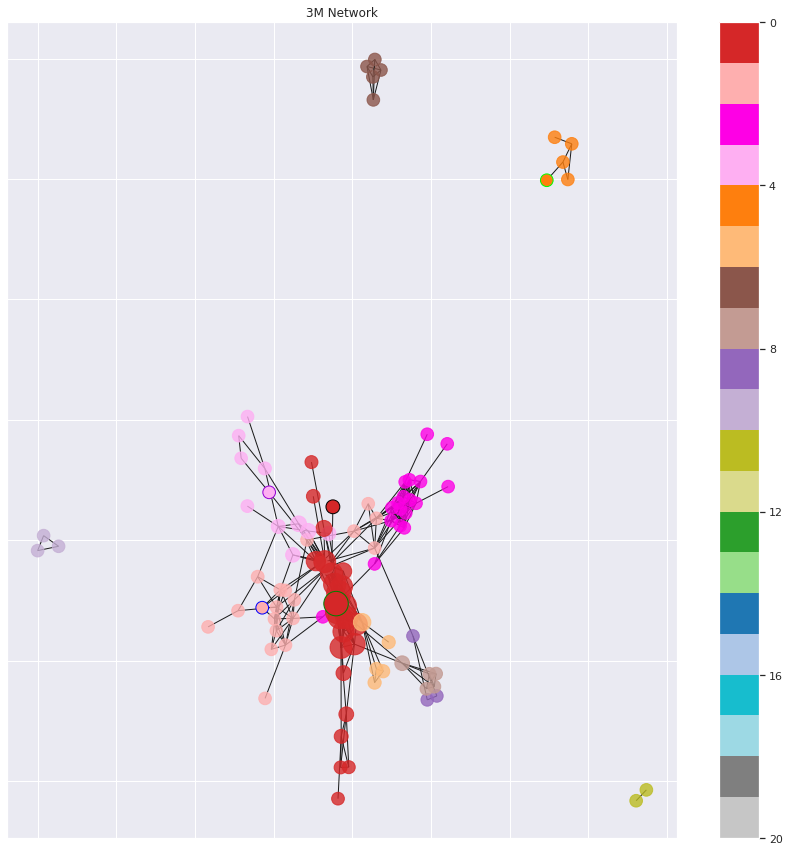

In [62]:
nap.visualize_network_fancy(G_3M)

## Eigengene Analysis

In [63]:
df_eigengenes_1C

,1C3A,1C3B,1C5A,1C5B,1C7A,1C7B,1C10A,1C10B,1C20B,1C20A
0,-0.143599,0.117358,0.569715,-4.287490e-01,3.575977e-01,-2.363195e-01,7.160380e-02,-4.101786e-01,1.043359e-02,3.162278e-01
1,0.226932,0.058755,0.316005,1.740591e-01,5.134902e-01,2.184239e-01,-5.062648e-01,3.356345e-01,-1.858974e-01,-3.162278e-01
2,-0.551953,-0.654230,0.335321,-1.776001e-01,-4.737961e-02,1.135660e-01,7.932525e-02,-4.250870e-02,1.041949e-02,3.162278e-01
3,0.164921,-0.151426,0.044160,8.336930e-01,-2.937392e-01,-7.091415e-02,2.419077e-01,-5.330468e-02,-1.430578e-02,-3.162278e-01
4,-0.105409,0.993736,-0.037118,-7.259869e-17,2.009679e-16,-7.259869e-17,-7.643385e-17,-8.026901e-17,-7.451627e-17,-6.830880e-17
5,-0.074287,0.160856,-0.978796,1.209931e-02,5.988175e-03,3.905591e-03,-8.759434e-02,-4.223373e-02,2.320956e-04,-3.019232e-02
6,-0.434972,0.082391,-0.226026,6.169817e-01,1.272320e-01,-9.730472e-02,-2.808826e-01,-9.761673e-02,1.830883e-01,4.739777e-01
7,-0.279047,0.034065,0.126909,-2.052577e-01,4.832996e-01,-2.635669e-01,5.015906e-01,4.112926e-01,-2.635669e-01,-2.635669e-01


In [64]:
import seaborn as sns; sns.set_theme(color_codes=True)

### Visualize Eigengenes
These are the main patterns of variation across samples

Text(0.5, 0.98, '3M Module Eigengenes')

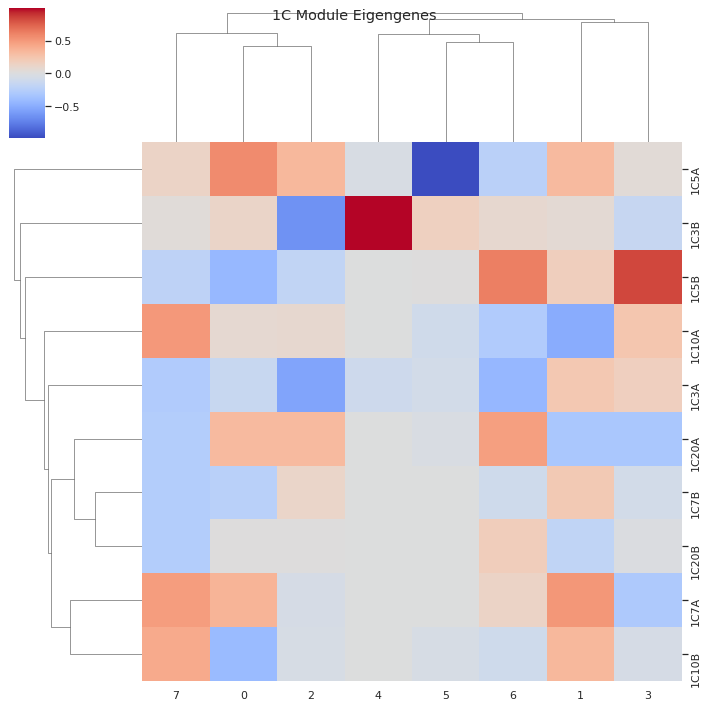

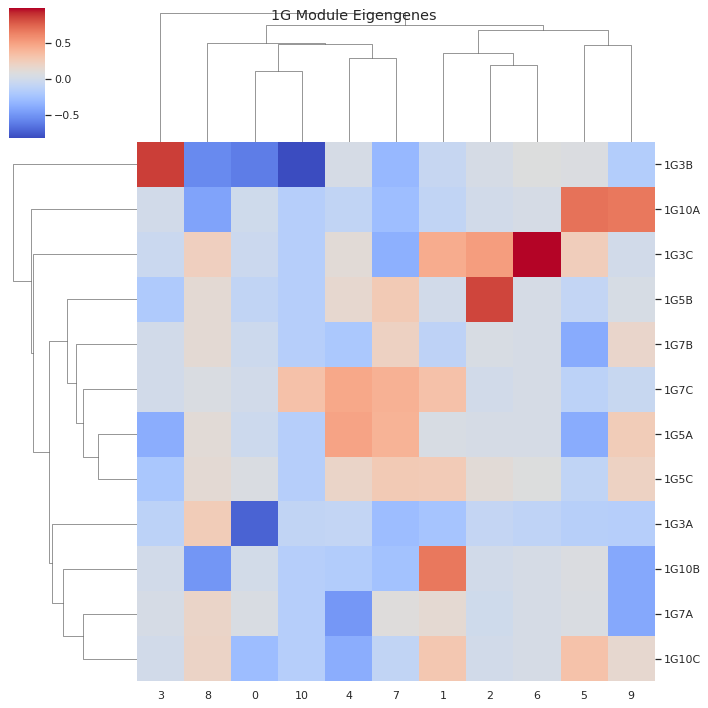

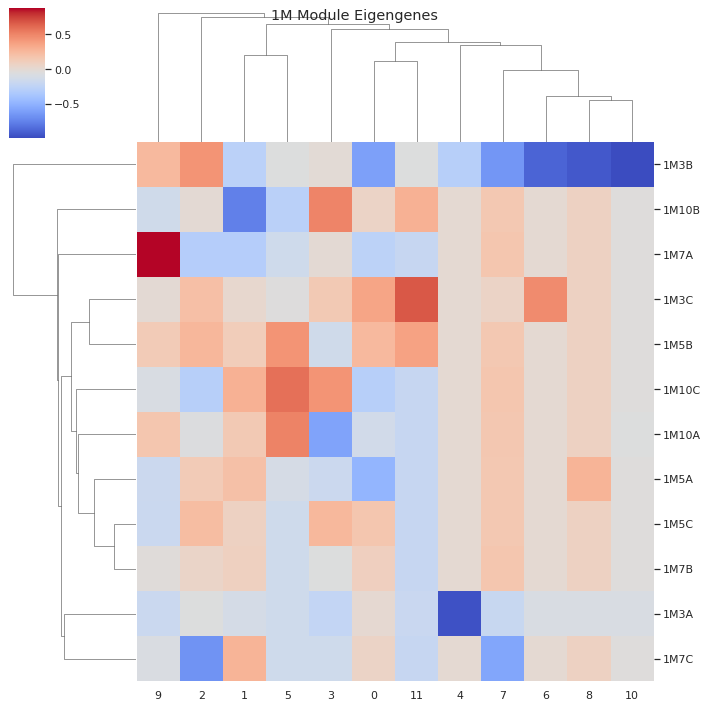

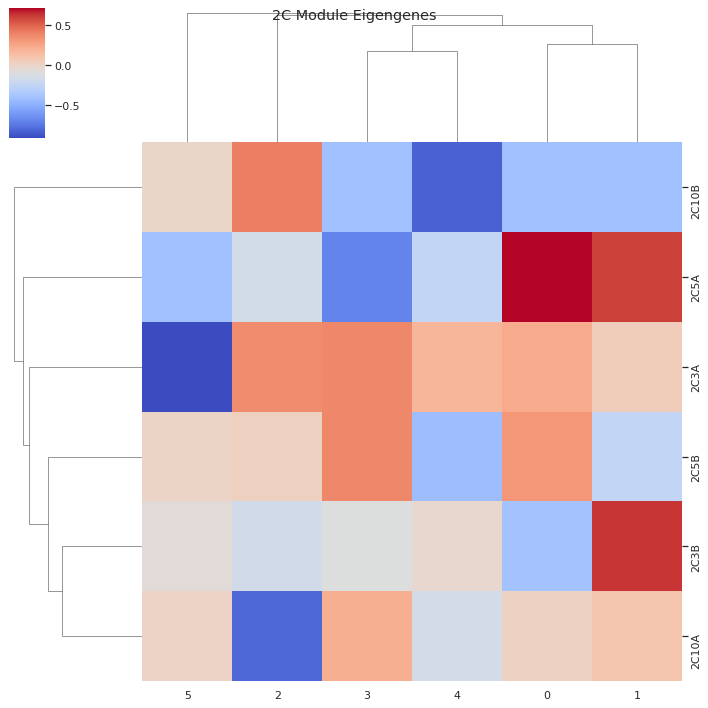

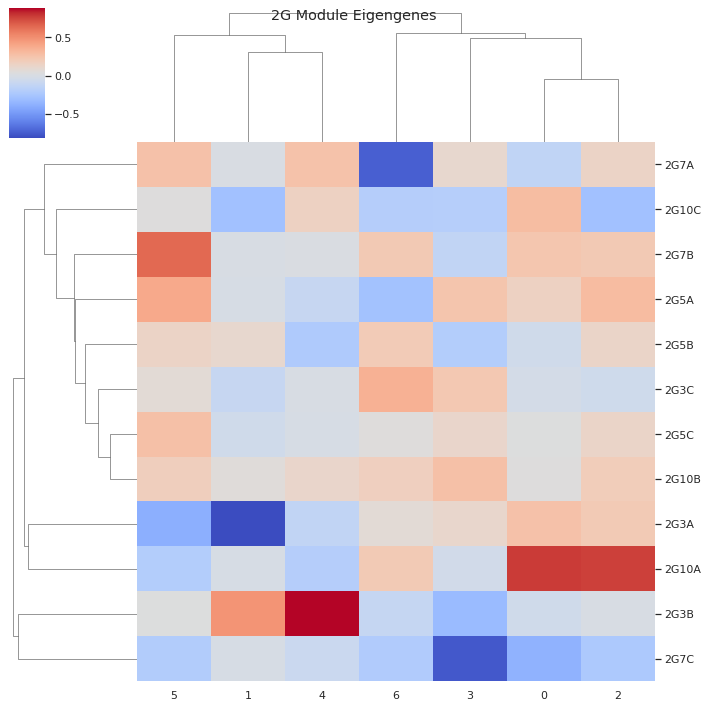

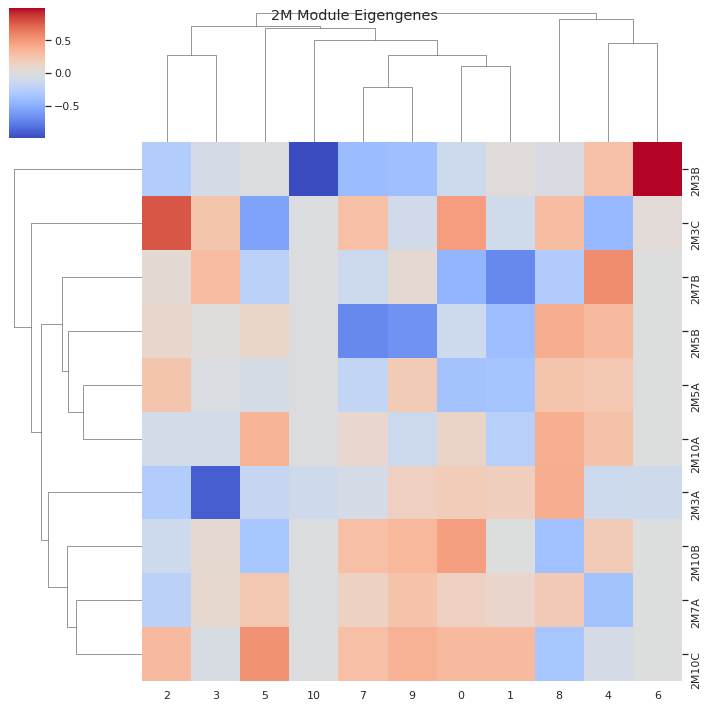

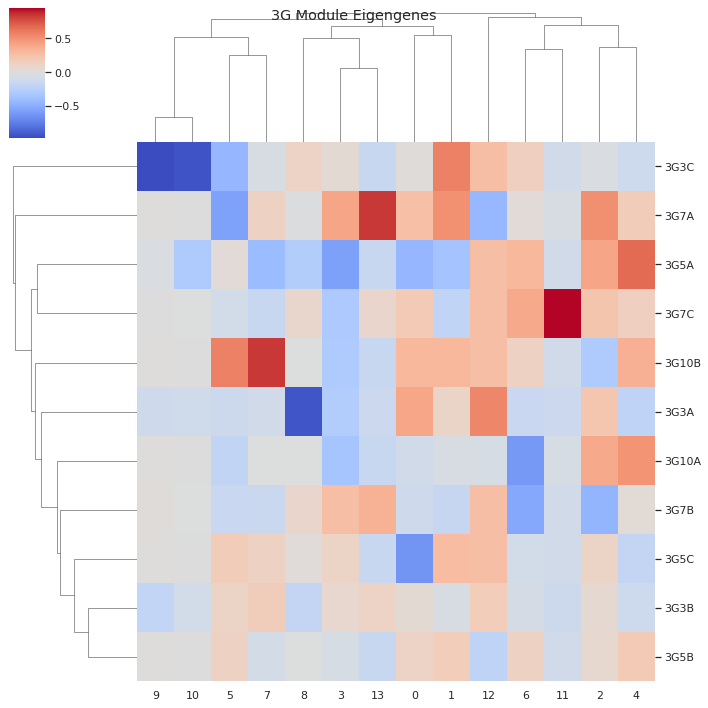

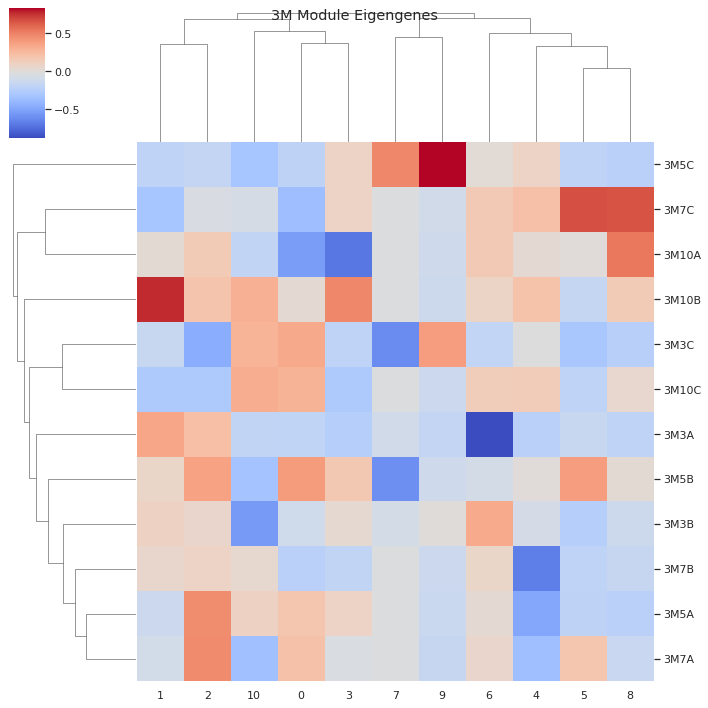

In [65]:
sns.clustermap(df_eigengenes_1C.T, cmap="coolwarm").fig.suptitle('1C Module Eigengenes') 
sns.clustermap(df_eigengenes_1G.T, cmap="coolwarm").fig.suptitle('1G Module Eigengenes') 
sns.clustermap(df_eigengenes_1M.T, cmap="coolwarm").fig.suptitle('1M Module Eigengenes') 
sns.clustermap(df_eigengenes_2C.T, cmap="coolwarm").fig.suptitle('2C Module Eigengenes') 
sns.clustermap(df_eigengenes_2G.T, cmap="coolwarm").fig.suptitle('2G Module Eigengenes') 
sns.clustermap(df_eigengenes_2M.T, cmap="coolwarm").fig.suptitle('2M Module Eigengenes') 
sns.clustermap(df_eigengenes_3G.T, cmap="coolwarm").fig.suptitle('3G Module Eigengenes') 
sns.clustermap(df_eigengenes_3M.T, cmap="coolwarm").fig.suptitle('3M Module Eigengenes') 